# import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import statsmodels.api as sm
import statsmodels
from scipy import stats


from arch import arch_model

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


import shap

from utils import optimal_params, fit_check, tree_feature_select, output_html
SEED = 20221024

/Users/jacky/miniforge3/envs/crypto/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_data = pd.read_csv("../data/data_1.csv")
date = df_data.date
df_data.set_index("date", inplace=True)
df_data.drop('bitcoin_price', axis=1, inplace=True)
df_data = df_data.dropna()

X = df_data.drop('btc_lagged_return', axis=1)
y = df_data.btc_lagged_return

features = X.columns

# bagging random forest

In [3]:
param_grid = {
    'random_state': [SEED],
    'n_jobs': [-1],
    'n_estimators': [450],
    'max_depth' : [11],
    'min_samples_leaf': [2],
    'max_features': ['sqrt']
}
fold_range = [int(i) for i in np.linspace(3, 50, 3)]
k, best_param, cv_score, rf = optimal_params(X,
                                             y,
                                             RandomForestRegressor(),
                                             param_grid,
                                             fold_range,
                                             verbose=0)
"""
optimal K: 3
best params: {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 450, 'n_jobs': -1, 'random_state': 20221024}
best cv score(RMSE): 0.04109635291694643
"""
print(f"optimal K: {k}")
print(f"best params: {best_param}")
print(f"best cv score(RMSE): {-cv_score}")

optimal K: 3
best params: {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 450, 'n_jobs': -1, 'random_state': 20221024}
best cv score(RMSE): 0.04491146924834808


# model fitness

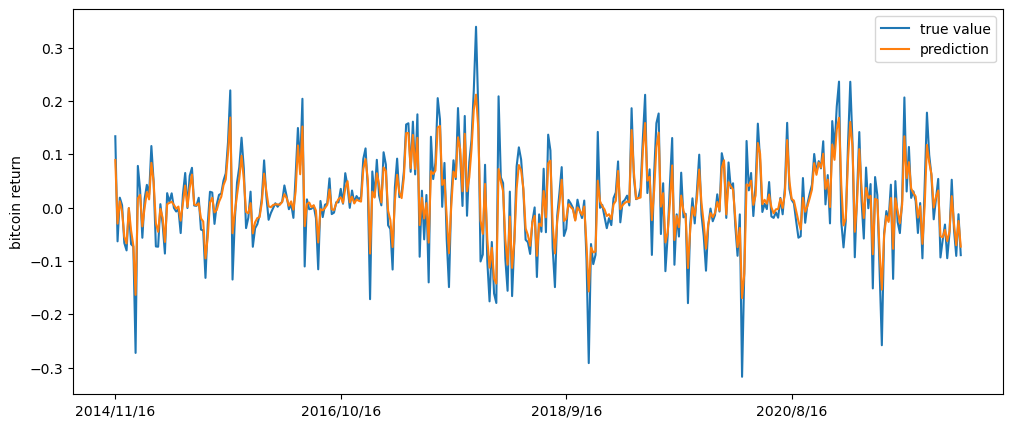

RMSE: 0.03227804108514959


In [4]:
y_pred = pd.DataFrame(rf.predict(X))
plt.figure(figsize=(12,5))
print(f"RMSE: {fit_check(y, y_pred)}")
# plt.savefig('./res/picture/rf_fit.png')
# RMSE: 0.03227804108514959

# importance analysis

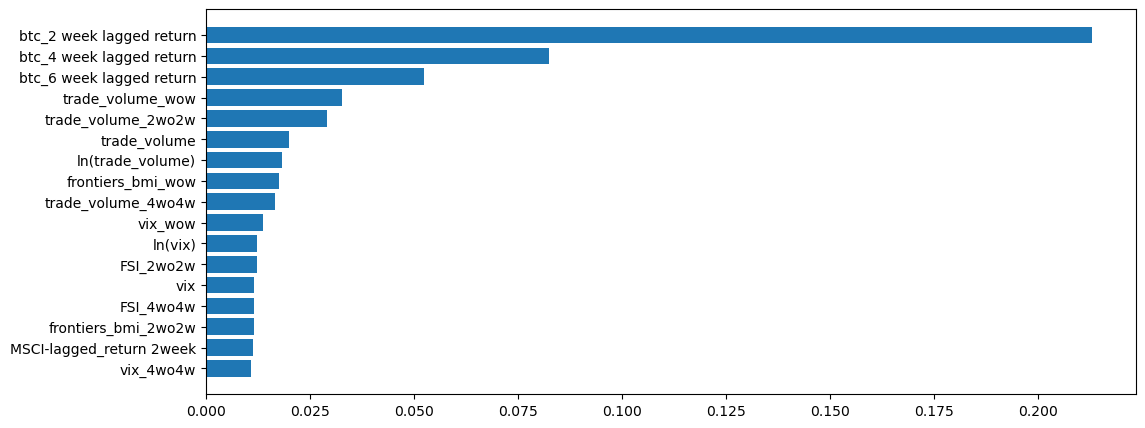

In [5]:
plt.figure(figsize=(12,5))
new_features = tree_feature_select(model=rf, features=X.columns, level=0.01)

# Shapley(SHAP) values

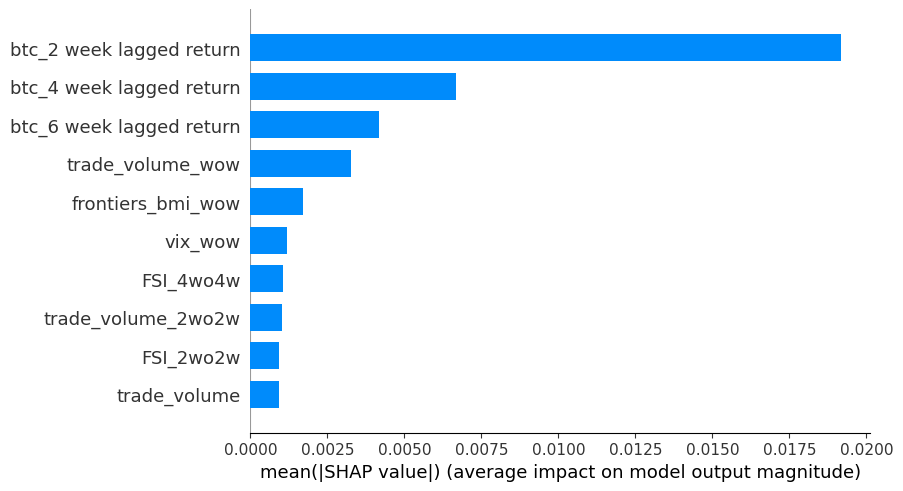

In [135]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)


shap.summary_plot(shap_values, X, plot_type='bar', max_display=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


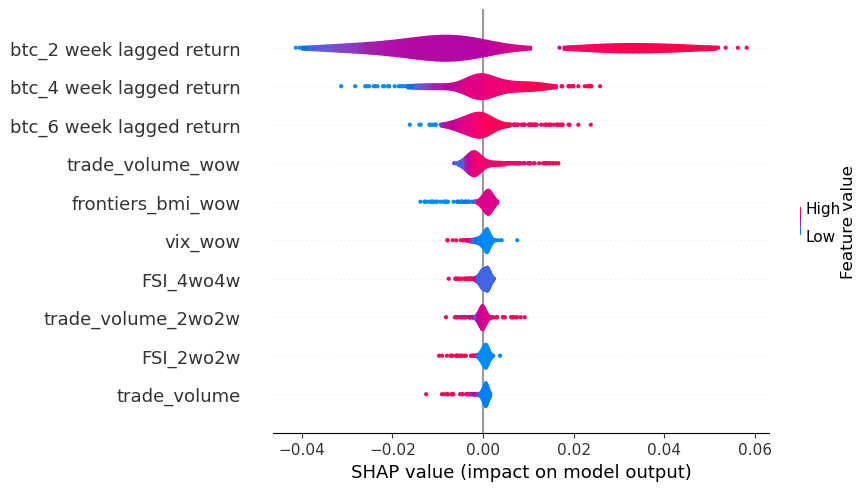

In [153]:
shap.summary_plot(shap_values, X, plot_type='violin', feature_names=features, max_display=10)

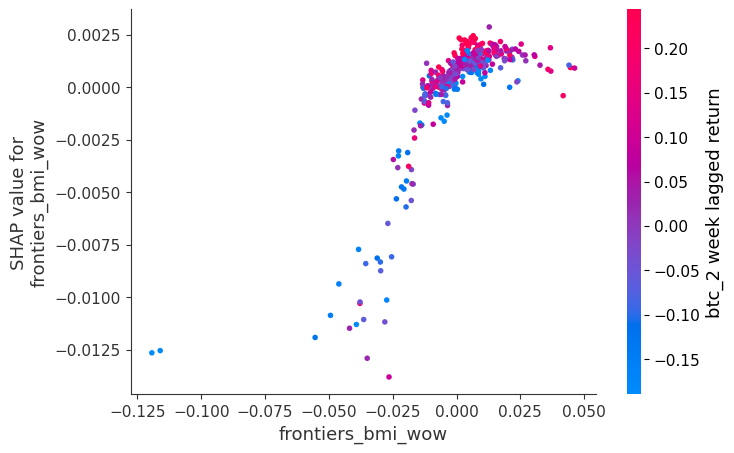

In [152]:
shap.dependence_plot("frontiers_bmi_wow", shap_values, X)

# residual analysis

Augmented Dickey-Fuller test of residual: p = 2.453168191226267e-19


<Figure size 1200x500 with 0 Axes>

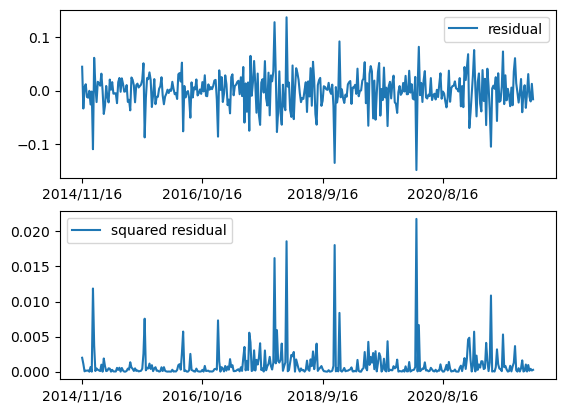

In [13]:
rf_resid = y.to_numpy() - y_pred.to_numpy().flatten()
rf_resid_square = np.square(rf_resid)

plt.figure(figsize=(12,5))
fig, axs = plt.subplots(2)

axs[0].plot(X.index, rf_resid, label="residual")
axs[0].legend()
axs[0].set_xticks(X.index[::100])

axs[1].plot(X.index, rf_resid_square, label="squared residual")
axs[1].legend()
axs[1].set_xticks(X.index[::100])

# plt.savefig('./res/picture/rf_resid_overview.png')

adf_resid = sm.tsa.stattools.adfuller(rf_resid)
print(f"Augmented Dickey-Fuller test of residual: p = {adf_resid[1]}")

In [16]:
# sm.graphics.tsa.plot_acf(resid_square, lags=1);
# sm.graphics.tsa.plot_pacf(resid_square, lags=1);
from statsmodels.iolib.table import SimpleTable

rf_acf = statsmodels.tsa.stattools.acf(rf_resid_square)
rf_pacf = statsmodels.tsa.stattools.pacf(rf_resid_square)

tbl_data = []
lag = 3
for i in range(1, lag+1):
    tbl_data.append([rf_acf[i], rf_pacf[i]])

myheaders = ["acf", "pacf"]
mystubs = ["lag1", "lag2", "lag3"]
tbl = SimpleTable(tbl_data, myheaders, mystubs, title="square of residual")
# output_html('./res/html/rf_acf.html', tbl)
tbl

,acf,pacf
lag1,0.022426051561734474,0.022485854365899085
lag2,0.06004377367003495,0.059889530686242094
lag3,-0.016853023841831967,-0.019691852984365956


In [17]:
test_arch_effect = sm.OLS(rf_resid_square[1:], rf_resid_square[:len(rf_resid_square)-1]).fit()

# output_html('./res/html/rf_arch_test.html', test_arch_effect.summary().tables[1])
test_arch_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.033
Model:                            OLS   Adj. R-squared (uncentered):              0.030
Method:                 Least Squares   F-statistic:                              12.58
Date:                Mon, 31 Oct 2022   Prob (F-statistic):                    0.000439
Time:                        11:22:16   Log-Likelihood:                          1707.6
No. Observations:                 375   AIC:                                     -3413.
Df Residuals:                     374   BIC:                                     -3409.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1803      0.051      3.547      0.000       0.080       0.280
==============================================================================
Omnibus:                      420.276   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19069.120
Skew:                           5.118   Prob(JB):                         0.00
Kurtosis:                      36.401   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

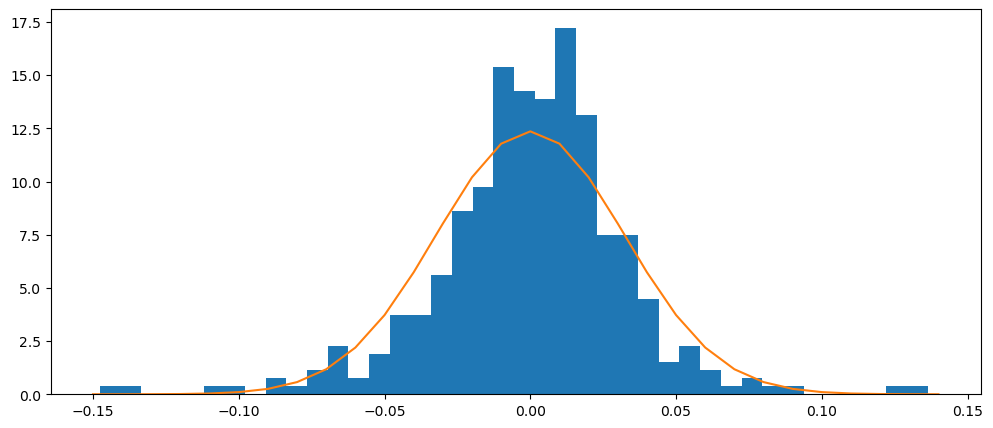

In [19]:
plt.figure(figsize=(12,5))
plt.hist(rf_resid, density=True, bins=40)

x_axis = np.arange(-0.15, 0.15, 0.01)
    
# # Calculating mean and standard 
# # deviation
mean = np.mean(rf_resid)
sd = np.std(rf_resid)
    
plt.plot(x_axis, stats.norm.pdf(x_axis, mean, sd))
plt.show()
# plt.savefig('./res/picture/rf_arch_resid_dist.png')

In [113]:
garch = arch_model(rf_resid, mean='Zero', vol='GARCH', p=1, q=1,rescale=False, dist='t')
garch_fit = garch.fit()

# output_html('./res/html/rf_garch_res.html', res_fit.summary())
garch_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -407.6814453003976
Iteration:      2,   Func. Count:     12,   Neg. LLF: -776.3317977682277
Iteration:      3,   Func. Count:     18,   Neg. LLF: 335.8617404182516
Iteration:      4,   Func. Count:     26,   Neg. LLF: -778.7270901852705
Iteration:      5,   Func. Count:     32,   Neg. LLF: -492.9168014073864
Iteration:      6,   Func. Count:     38,   Neg. LLF: -774.778325901289
Iteration:      7,   Func. Count:     44,   Neg. LLF: -406.9244947456463
Iteration:      8,   Func. Count:     50,   Neg. LLF: -787.5721648592943
Iteration:      9,   Func. Count:     56,   Neg. LLF: -790.1314521513176
Iteration:     10,   Func. Count:     61,   Neg. LLF: -790.0950092089968
Iteration:     11,   Func. Count:     67,   Neg. LLF: -790.1573014529406
Iteration:     12,   Func. Count:     72,   Neg. LLF: -790.1587631176204
Iteration:     13,   Func. Count:     77,   Neg. LLF: -790.1587661480982
Iteration:     14,   Func. Count:     81,   Neg. LLF:

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.003
Vol Model:                            GARCH   Log-Likelihood:                790.159
Distribution:      Standardized Student's t   AIC:                          -1572.32
Method:                  Maximum Likelihood   BIC:                          -1556.60
                                              No. Observations:                  376
Date:                      Mon, Oct 31 2022   Df Residuals:                      376
Time:                              15:41:36   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4374e-04  5.256e-05      2.735  6.245e-03 [4.072e-05,2.468e-04]
alpha[1]       0.2442      0.116      2.109  3.492e-02   [1.728e-02,  0.471]
beta[1]        0.6622  8.801e-02      7.525  5.283e-14     [  0.490,  0.835]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.2868      0.922      4.650  3.311e-06 [  2.480,  6.094]
========================================================================

Covariance estimator: robust
"""

In [150]:
gjr_garch = arch_model(rf_resid, mean='Zero', vol='GARCH', p=1, o=1, q=1,rescale=False, dist='t')
gjr_garch_fit = gjr_garch.fit()

# output_html('./res/html/rf_garch_res.html', res_fit.summary())
gjr_garch_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -735.4647752377535
Iteration:      2,   Func. Count:     16,   Neg. LLF: -643.9968581154312
Iteration:      3,   Func. Count:     23,   Neg. LLF: -427.5417259331749
Iteration:      4,   Func. Count:     30,   Neg. LLF: -777.9755819932435
Iteration:      5,   Func. Count:     37,   Neg. LLF: -500.2825169562012
Iteration:      6,   Func. Count:     44,   Neg. LLF: -785.5268420968155
Iteration:      7,   Func. Count:     51,   Neg. LLF: -784.2611753911667
Iteration:      8,   Func. Count:     58,   Neg. LLF: -789.7111952006879
Iteration:      9,   Func. Count:     65,   Neg. LLF: -788.6743568664187
Iteration:     10,   Func. Count:     72,   Neg. LLF: -791.0873427232482
Iteration:     11,   Func. Count:     79,   Neg. LLF: -790.9125668825725
Iteration:     12,   Func. Count:     86,   Neg. LLF: -791.6510039447555
Iteration:     13,   Func. Count:     93,   Neg. LLF: -791.6547246243908
Iteration:     14,   Func. Count:     99,   Neg. LL

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - GJR-GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.003
Vol Model:                        GJR-GARCH   Log-Likelihood:                791.655
Distribution:      Standardized Student's t   AIC:                          -1573.31
Method:                  Maximum Likelihood   BIC:                          -1553.66
                                              No. Observations:                  376
Date:                      Mon, Oct 31 2022   Df Residuals:                      376
Time:                              16:50:25   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0630e-04  5.197e-05      2.045  4.081e-02 [4.445e-06,2.082e-04]
alpha[1]       0.3221      0.142      2.266  2.343e-02   [4.354e-02,  0.601]
gamma[1]      -0.2263      0.119     -1.898  5.771e-02   [ -0.460,7.399e-03]
beta[1]        0.7315      0.119      6.161  7.227e-10     [  0.499,  0.964]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.1842      0.922      4.537  5.694e-06 [  2.377,  5.992]
========================================================================

Covariance estimator: robust
"""

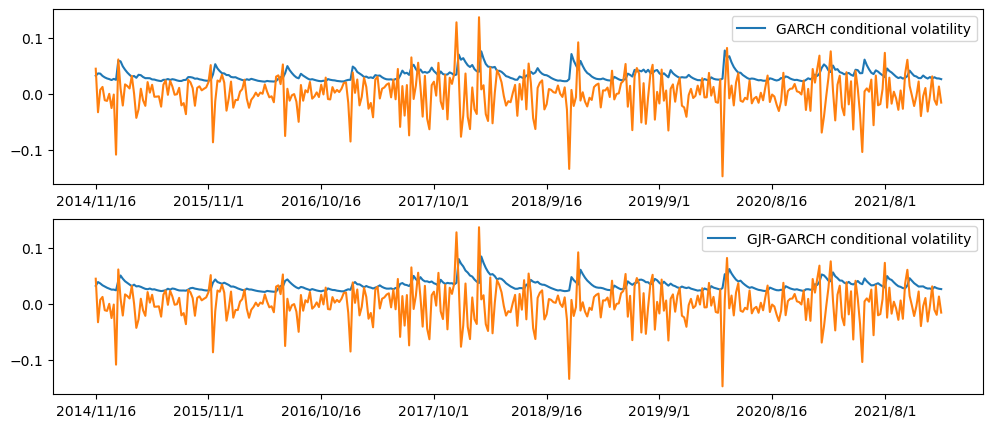

In [130]:
fig, axs = plt.subplots(2, figsize=(12, 5))
axs[0].plot(X.index, garch_fit.conditional_volatility, label="GARCH conditional volatility")
axs[0].plot(X.index, rf_resid)
axs[0].set_xticks(X.index[::50])
axs[0].legend()
axs[1].plot(X.index, gjr_garch_fit.conditional_volatility, label="GJR-GARCH conditional volatility")
axs[1].plot(X.index, rf_resid)
axs[1].set_xticks(X.index[::50])
axs[1].legend();

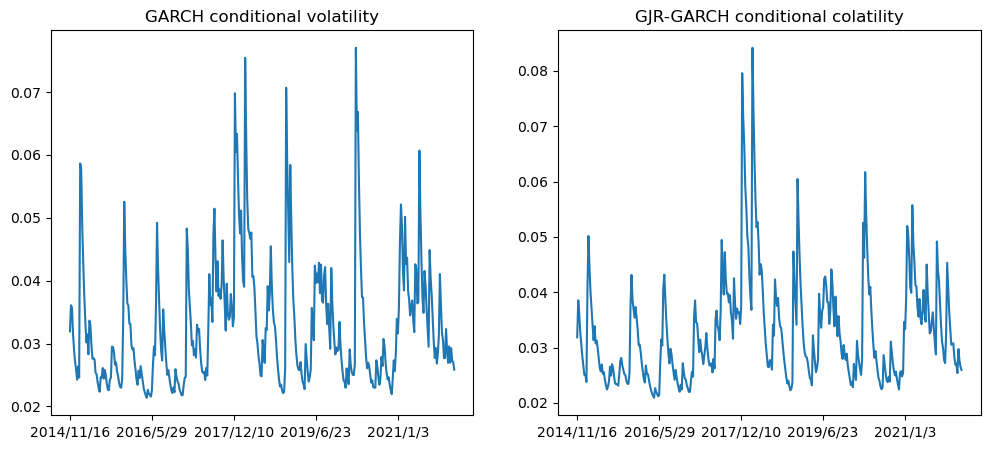

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(X.index, garch_fit.conditional_volatility)
axs[0].set_xticks(X.index[::80])
axs[0].set_title("GARCH conditional volatility")
axs[1].plot(X.index, gjr_garch_fit.conditional_volatility)
axs[1].set_title("GJR-GARCH conditional colatility")
axs[1].set_xticks(X.index[::80]);

# Boosting XGB

In [29]:
param_grid = {
    'seed': [SEED],
    'n_estimators': [int(x) for x in np.linspace(2, 1000, 5)],
}

fold_range = [int(i) for i in range(3, 30, 5)]
k, best_param, cv_score, xgb = optimal_params(X,
                                         y,
                                         XGBRegressor(),
                                         param_grid,
                                         fold_range,
                                         verbose=0)
"""
"""
print(f"optimal K: {k}")
print(f"best params: {best_param}")
print(f"best cv score(RMSE): {-cv_score}")

optimal K: 3
best params: {'n_estimators': 251, 'seed': 20221024}
best cv score(RMSE): 0.04871530655209492


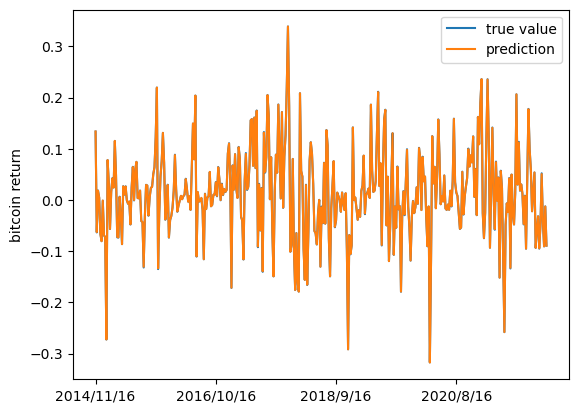

RMSE: 0.0005180302873492633


In [122]:
y_pred = pd.DataFrame(xgb.predict(X))
print(f"RMSE: {fit_check(y, y_pred)}")
# 0plt.savefig('./res/picture/xgb_fit.png')
# RMSE: 0.07265103252228707

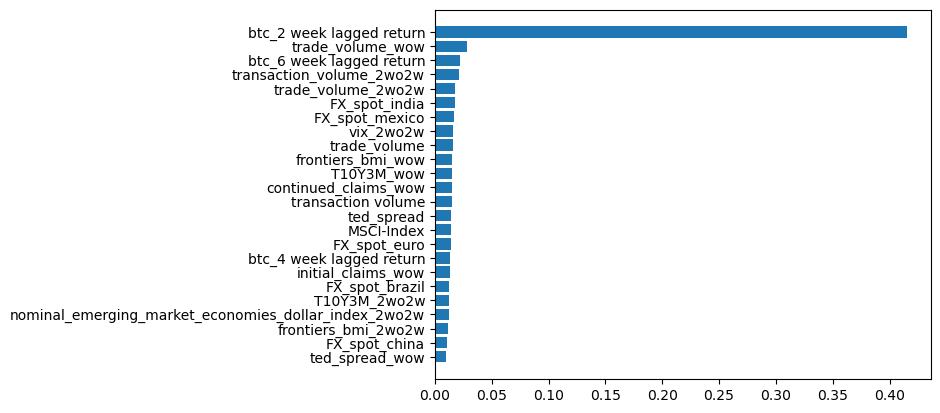

In [33]:
new_features = tree_feature_select(model=xgb, features=X.columns, level=0.01)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


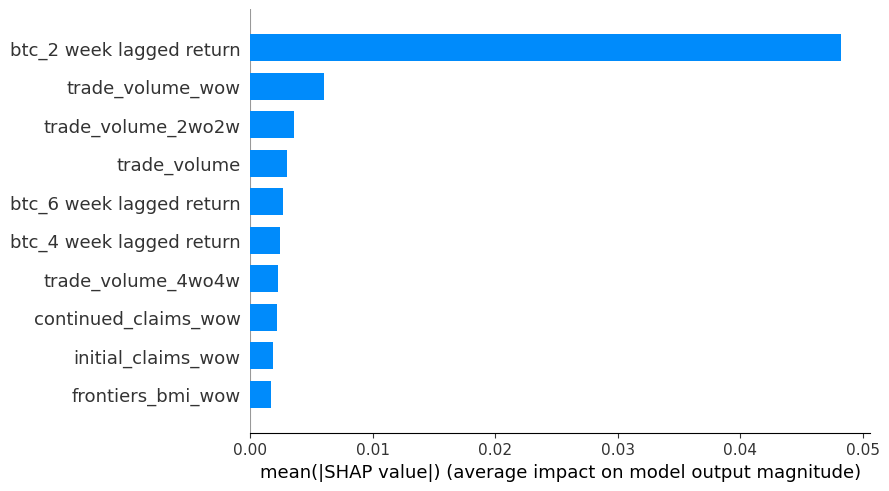

In [34]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)


shap.summary_plot(shap_values, X, plot_type='bar', max_display=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


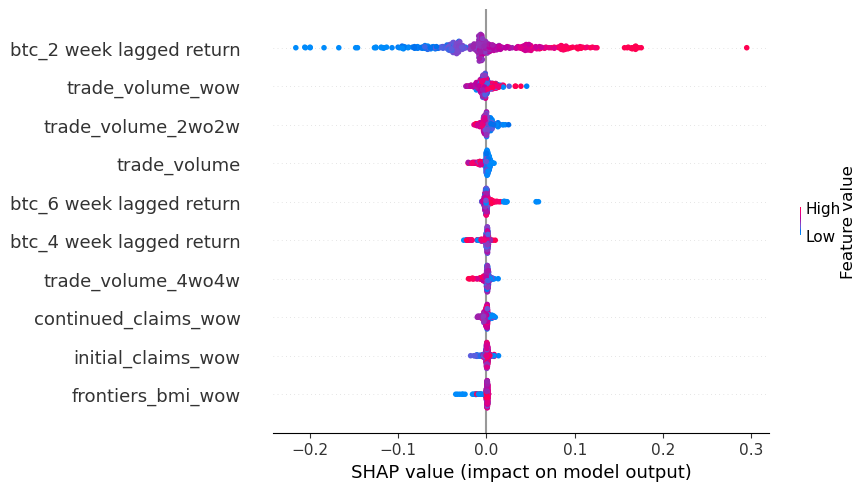

In [35]:
shap.summary_plot(shap_values, X, plot_type='dot', feature_names=features, max_display=10)

Augmented Dickey-Fuller test of residual: p = 4.543501941264156e-26


<Figure size 1200x500 with 0 Axes>

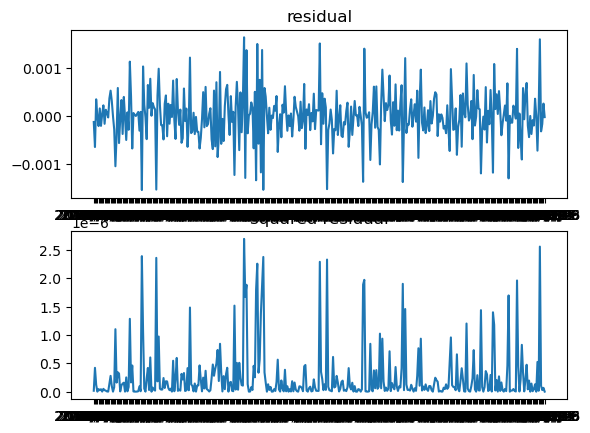

In [125]:
xgb_resid = y.to_numpy() - y_pred.to_numpy().flatten()
xgb_resid_square = np.square(xgb_resid)

plt.figure(figsize=(12,5))
fig, axs = plt.subplots(2)

axs[0].plot(X.index, xgb_resid)
axs[0].set_title('residual')
# axs[0].xticks(X.index[::100]);

axs[1].plot(X.index, xgb_resid_square)
axs[1].set_title('squared residual')
# plt.xticks(X.index[::100]);

# plt.savefig('./res/picture/xgb_resid_overview.png')

adf_resid = sm.tsa.stattools.adfuller(xgb_resid)
print(f"Augmented Dickey-Fuller test of residual: p = {adf_resid[1]}")

In [53]:
# sm.graphics.tsa.plot_acf(resid_square, lags=1);
# sm.graphics.tsa.plot_pacf(resid_square, lags=1);
from statsmodels.iolib.table import SimpleTable

xgb_acf = statsmodels.tsa.stattools.acf(resid_square)
xgb_pacf = statsmodels.tsa.stattools.pacf(resid_square)

tbl_data = []
lag = 3
for i in range(1, lag+1):
    tbl_data.append([xgb_acf[i], xgb_pacf[i]])

myheaders = ["acf", "pacf"]
mystubs = ["lag1", "lag2", "lag3"]
tbl = SimpleTable(tbl_data, myheaders, mystubs, title="square of residual")
output_html('./res/html/xgb_acf.html', tbl)
tbl

,acf,pacf
lag1,0.18029713935792196,0.18077793172954307
lag2,0.07337512788410573,0.04247495731059555
lag3,-0.05088943148545057,-0.07430436486643192


In [54]:
test_arch_effect = sm.OLS(xgb_resid_square[1:], xgb_resid_square[:len(resid_square)-1]).fit()

output_html('./res/html/xgb_arch_test.html', test_arch_effect.summary().tables[1])
test_arch_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.136
Model:                            OLS   Adj. R-squared (uncentered):              0.134
Method:                 Least Squares   F-statistic:                              59.06
Date:                Sun, 30 Oct 2022   Prob (F-statistic):                    1.36e-13
Time:                        21:30:23   Log-Likelihood:                          4893.3
No. Observations:                 375   AIC:                                     -9785.
Df Residuals:                     374   BIC:                                     -9781.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3693      0.048      7.685      0.000       0.275       0.464
==============================================================================
Omnibus:                      212.682   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1266.091
Skew:                           2.448   Prob(JB):                    1.18e-275
Kurtosis:                      10.554   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
mdl_garch = arch_model(xgb_resid, mean='Zero', vol='GARCH', p=1, q=1,rescale=False, dist='t')
res_fit = mdl_garch.fit()

output_html('./res/html/xgb_garch_res.html', res_fit.summary())
res_fit.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -2325.9616890122306
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -2325.9616890235493
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.



<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.003
Vol Model:                            GARCH   Log-Likelihood:                2325.96
Distribution:      Standardized Student's t   AIC:                          -4643.92
Method:                  Maximum Likelihood   BIC:                          -4628.21
                                              No. Observations:                  376
Date:                      Sun, Oct 30 2022   Df Residuals:                      376
Time:                              21:32:26   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3418e-07  3.799e-09     35.322 2.736e-273 [1.267e-07,1.416e-07]
alpha[1]       0.1000  5.954e-02      1.680  9.303e-02  [-1.669e-02,  0.217]
beta[1]        0.4000  8.116e-02      4.928  8.295e-07     [  0.241,  0.559]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             8.2593      1.183      6.981  2.927e-12 [  5.941, 10.578]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

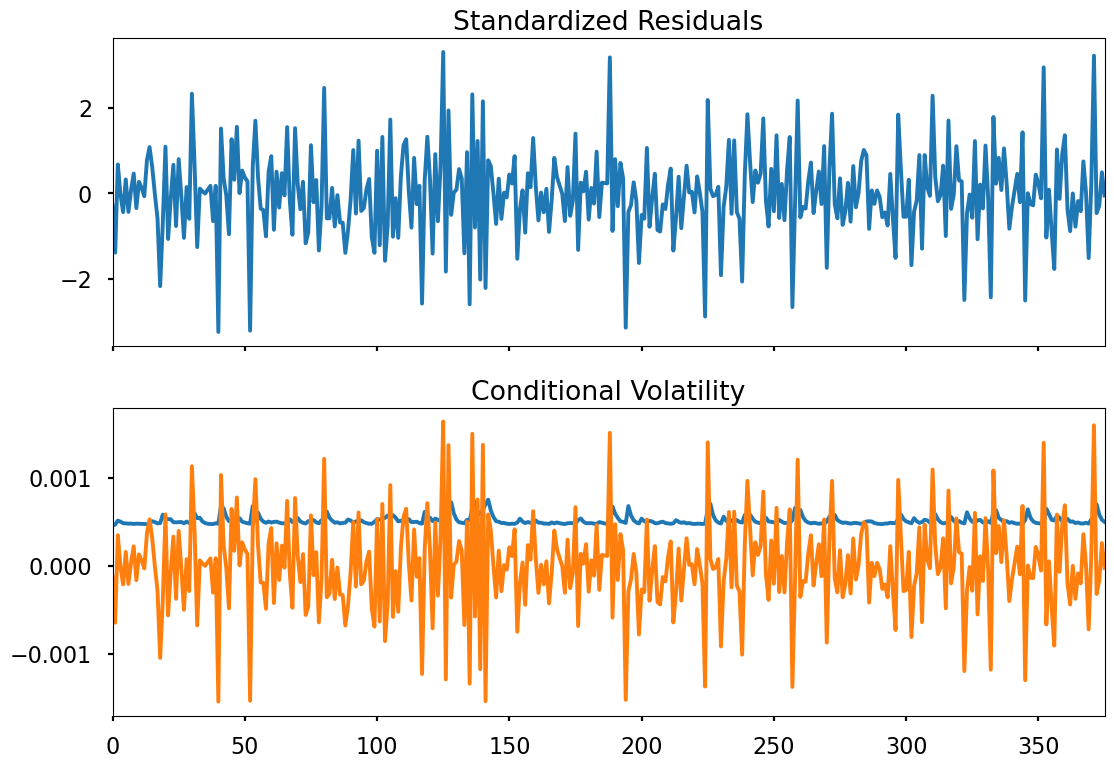

In [65]:
res_fit.plot()
plt.plot(resid)
plt.savefig('xgb_arch_volatility.png')